# The Golden (Hour) State:
## *California Solar Irradiance Analysis Using Meteorological Data from 1998-2019*



### Mark Goldman (mg3777) | G. Thorsteinsson (gt2447)

Setting up: Importing libraries, setting properties, loading utils, mounting Google Drive etc.

In [ ]:
# To speed up (only needed for part 5):
# Runtime -> Change Runtime Type -> GPU

# File setup. Follow the prompt that appears when run
from google.colab import drive
prefix = '/content/drive/'
drive.mount(prefix)

import os
import csv
import json
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.image as image
import geopy.distance
from shapely.geometry import Point
import sklearn
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as layers

# NOTE: Be careful here. 'grep...' is to suppress unncessary info
!pip install geopandas | grep -v 'already satisfied' || true
import geopandas as gpd
!pip install rasterio | grep -v 'already satisfied' || true
import rasterio

proj_dir = f'{prefix}MyDrive/Spring 2021/' \
           f'Environmental Data Analysis & Modeling/Project/'
data_dir = f'{proj_dir}data/'

# Load locations and their respective coordinates
with open(f'{data_dir}/utils/locations.json', 'r') as fp:
    locs = json.load(fp)

# Load colors and their respective hex-codes
with open(f'{data_dir}utils/colors.json', 'r') as fp:
    colors = json.load(fp)
    
# Create a monochromatic Columbia-like colormap
cmap = matplotlib.colors.ListedColormap(colors['blue'])

def plot_size(x, y, dpi):
    """Remedy to the awkward notebook plt figure sizes"""
    
    plt.rcParams['figure.figsize'] = [x, y]
    plt.rcParams['figure.dpi'] = dpi

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Data Preprocessing

The data is in csv-files, one file for each year for each location. We want to concatenate every year into one file for each location. Ideally we'd concatenate all the data into one file, but the sheer magnitude (~116 M data points) makes that infeasible. Note that we write the data to zip-files - pandas can read them straight into a dataframe. We will ex
tensively make use of this functionality. 

<font color='red'>NOTE</font>: Don't run this code block unless making changes to it

In [ ]:
locs = dict()  # Will contain all locations (str) and corresponding coordinates

def get_crds(name):
    """Extracts lat & lon from filename"""

    coords = name.split('_')
    lat = float(coords[1])
    lon = float(coords[2])

    return [lon, lat]

# Concatenate each location into one file
for loc in os.listdir(f'{data_dir}raw/'):
    sub_dir_name = os.path.join(f'{data_dir}raw/', loc)
    L = len(os.listdir(sub_dir_name))  # Number of files for location
    for i, file in enumerate(os.listdir(sub_dir_name)):
        name = os.fsdecode(file)  # Just the filename, not the dir
        df = pd.read_csv(f'{sub_dir_name}/{name}',
                         skiprows=2)
        # Last column just contains NA values
        df.drop(df.columns[len(df.columns)-1],
                axis=1,
                inplace=True)

        # Is only run the first time for each location
        if i == 0:
            locs[loc] = get_crds(name)

            N = df.shape[0]
            arr = np.zeros((N*L, df.shape[1]))  # Preallocating for speed
            cols = list(df.columns.str.lower())  # Extracting the column names
            df_new = pd.DataFrame(arr, columns=cols)  # Preallocating for speed

        df_new.iloc[i*N:(i+1)*N, :] = df.values  # Filling in the dataframe

    # WARNING: Takes a few mins to run  
    df_new.to_csv(f'{data_dir}processed/{loc}.zip',
                    index=False,
                    compression="zip")

# Save location and coordinates to be loaded later
with open(f'{data_dir}utils/location.json', 'w') as f:
    json.dump(locs, f)

# 1. Data Description

**a) Describe the dataset you are working with.**

California Solar Power Potential Mapped Using Meteorological Data from 1998-2019. Dataset is from
The National Renewable Energy Laboratory, a national laboratory of the U.S. Department of Energy.

While their database is vast, covering much of the United States, we selected 11 cities and 4 locations in California. The sites are relatively equally dispersed around California, considering latitude, longitude, and space from bodies of water.

The NSRDB deploys geostationary satellites that collect raw data in the form of aerosol properties, surface albedo, snow albedo, atmospheric profiles, and cloud properties. These measured values are plugged into a physics-based model to infer other features, such as GHI, DNI, and DHI.

The data we examine spans 1998 through 2019. Variables provided for each location are listed in the next cell.

We are going to model Direct Normal Irradiance (`DNI`) based on these variables as it is the most important predictor when assessing solar power potential (Schlecht & Meyer, 2012). We will use `DNI` and Irradiance interchangeably throughout this project. 

In [ ]:
for key in locs.keys():
    df = pd.read_csv(f'{data_dir}processed/{key}.zip')
    features = df.columns.tolist()
    break

print('DATASET FEATURES:')
for feature in features:
    print(feature)

DATASET FEATURES:
year
month
day
hour
minute
dhi
dni
ghi
clearsky dhi
clearsky dni
clearsky ghi
cloud type
dew point
solar zenith angle
fill flag
surface albedo
wind speed
precipitable water
wind direction
relative humidity
temperature
pressure
global horizontal uv irradiance (280-400nm)
global horizontal uv irradiance (295-385nm)


Let us plot the locations better understand the scope.

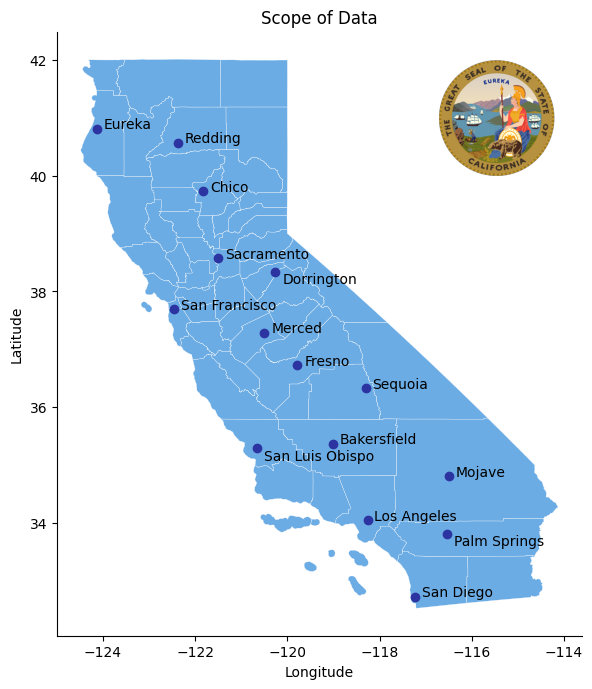

In [ ]:
plot_size(8, 8, 100)
fig, ax = plt.subplots()

# Inserting an image of the The Great Seal of California
im = image.imread(f'{data_dir}utils/Cali_Seal.png')
ax.imshow(im, extent=(-116.7, -114.2, 40, 42))  # Manual position

# Reading a shapefile of California into a geodataframe
raster_file = f'{data_dir}geospatial/CA_Counties_TIGER2016.shp'
gdf_cali = gpd.read_file(raster_file)
# Explicitly the coordinate system (otherwise scale will be off)
coord_str = '+proj=longlat +datum=WGS84 +no_defs'
crs = rasterio.crs.CRS.from_string(coord_str)
gdf_cali = gdf_cali.to_crs(crs=crs)

gdf_cali.plot(ax=ax,
              cmap=cmap,
              linewidth=0.2,
              edgecolor='white')

# Plotting the locations
overlap = ['San Luis Obispo', 'Dorrington', 'Palm Springs']
for key, val in locs.items():
    ax.scatter(val[0], val[1], c=colors['Blue'])
    # Prevent text overlapping
    v_offset = -0.2 if any([key==lap for lap in overlap]) else 0
    ax.text(val[0] + 0.15, val[1] + v_offset, key)

ax.set_title('Scope of Data')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

As this map reveals, we took care to try and choose locations spread throughout the state, especially choosing locations close to major municipalities (e.g. LA & San Francisco) and/or at optimal locations for solar production due to presumably favourable irradiance (e.g. Mojave, Sequoia). 

**b) Why it is necessary to apply statistical analysis to the dataset?**

Our goal is to model future behavior, namely the solar irradiance in the California for the short and long term. Without proper statistical analysis, or without statistical analysis at all, the use of solar panels may be misguided. Towns and regions should know how much irradiance they could expect, within a reasonable margin, so they are able to anticipate how much energy will be produced from their solar panels and compensate with any lack of supply by different means. This is only possible with the analysis and modeling of the data.

**c) How could humanity benefit from a better model/forecast of your dataset?**

As mentioned in the previous problem, a proper model/forecast of the dataset provides municipalities and regions with a reasonable estimate of how much energy they could anticipate from solar panels that they have set-up or will set-up. This allows them to plan accordingly to fill needs, should they need to compensate with other forms of energy. This can minimize the use of fossil fuels by allowing these local governments to accurately predict how many solar panels they will need and make the proper investments.

# 2. Temporal Trend Analysis


We utilize the powerful `Seaborn` package to create concise plots, revealing key temporal features.

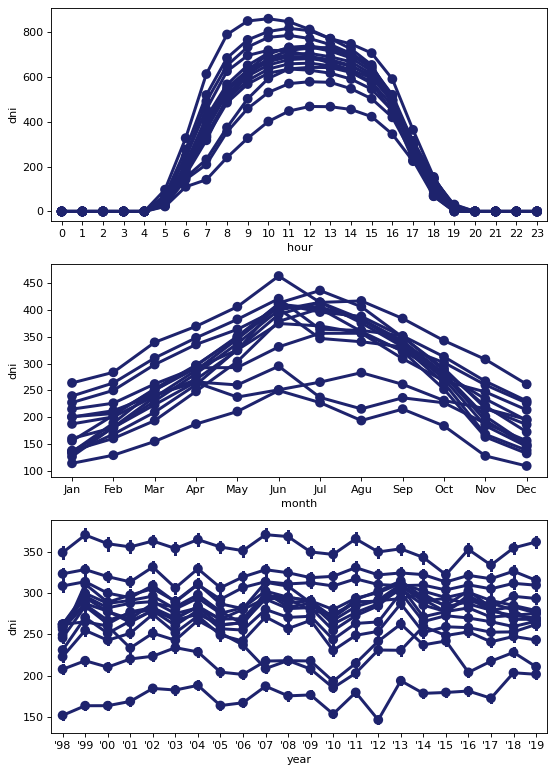

In [ ]:
class Temporal:
    """For plotting summary plots"""

    def __init__(self):
        self.fig, (self.ax1, self.ax2, self.ax3) = plt.subplots(nrows=3)
        plot_size(8, 12, 80)

    def set_properties(self):
        """We manually change the axes for every subfigure"""

        ax1_array = np.linspace(0, 23, 24)
        ax1_labels = [np.array2string(i)[:-1] for i in ax1_array]
        self.ax1.set_xticks(range(24))
        self.ax1.set_xticklabels(ax1_labels)

        ax2_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                      'Jul', 'Agu', 'Sep', 'Oct', 'Nov', 'Dec']
        self.ax2.set_xticks(range(12))
        self.ax2.set_xticklabels(ax2_labels)

        ax3_array = np.linspace(1998, 2019, 22)
        ax3_labels = [np.array2string(i) for i in ax3_array]
        ax3_labels = ["'" + i[2:4] for i in ax3_labels]
        self.ax3.set_xticks(range(22))
        self.ax3.set_xticklabels(ax3_labels)

    def plot(self, df, c):
        """Creating summary plots"""
        
        sns.pointplot(data=df, x='hour', y='dni', ax=self.ax1, color=c)
        sns.pointplot(data=df, x='month', y='dni', ax=self.ax2, color=c)
        sns.pointplot(data=df, x='year', y='dni', ax=self.ax3, color=c)
        self.set_properties()

temporal = Temporal()
for key in locs.keys():
    df = pd.read_csv(f'{data_dir}processed/{key}.zip')
    temporal.plot(df, c=colors['BLUE'])

These three plots have one curve for each location.


**a) Summarize seasonality and annual behavior of your dataset.**

The first graph outlines the average solar irradiance per hour (averaged across all 21 years) compared to the time of the day. As anticipated, we see no solar irradiance during the night (from around 20:00 to 4:00) along with a fast rise starting at 5, plateau/steady decline at 12:00, and a bigger decline starting at 16:00. This corresponds with the angle of the sun above the Earth and is not particularly noteworthy. The only interested feature is that we notice that some of these curves are skewed a little to the left or right. We believe several factors may attribute to this including geographical features of the area (e.g. mountains/valleys, bodies of water, etc.) and the difference in time vs location of the sun (while they are in the same timezone, the sun is actually at a different angle based on the longitude).

The second graph outlines the average solar irradiance per month (averaged each month across all 21 years) compared to the month. We see a linear increase from December to June/July, followed by a steady decrease from June/July to December. This coincides with the angle of the sun's ray's hitting California during the year, more directly (closer to 90 degrees) in the summer and less directly during the winter. There is a notable difference in peaks, some occuring in June and others in July, that we attirbute to the same phenomena that we mentioned earlier (geographical features, timezone).

The third graph outlines the change in average solar irradiance per year (365 day average for each year) compared to the year. We see no trend here, likely due to the very limited scope of the data. It is resonable to note see a significant change in solar irradiance during a 21-year period as there would be no significant changes in the environment during this time. Any change is likely mostly due to noise.

**b) What do your results tell you about the underlying environmental phenomenon?**

The first graph is consistent with the sun's change in angle, or presence, throughout the day. As it approaches noon, the sun will be at its "highest" point, or the closest to 90 degrees relative to the location. This means the rays will hit the ground (or solar panels) more directly and this means more irradiance. This certainly outlines the general trend though there are more factors that can influence it. For example, cities located in valleys may be more sheltered from the sun than cities on mountains, causing a skewed solar irradiance. These differences are not enough to completely change the trend - as shown in our data.

The second graph shows the environmental phenomenon of the Earth's rotation around the sun. During winter months the Sun is less directly hitting the northern hemisphere, so the solar irradiance is subsequently lower. The opposite is true for the summer months. This trend is outlined in our data.

The third graph shows that the previously mentioned phenomena do not vary greatly across the span of 20 years. This is likely due to the buffers, cycles, and capacities (thermal or otherwise) of the Earth.

There are two particularly anomalous curves. Recreating the plots with those two anomalies highlighted reveals the following.

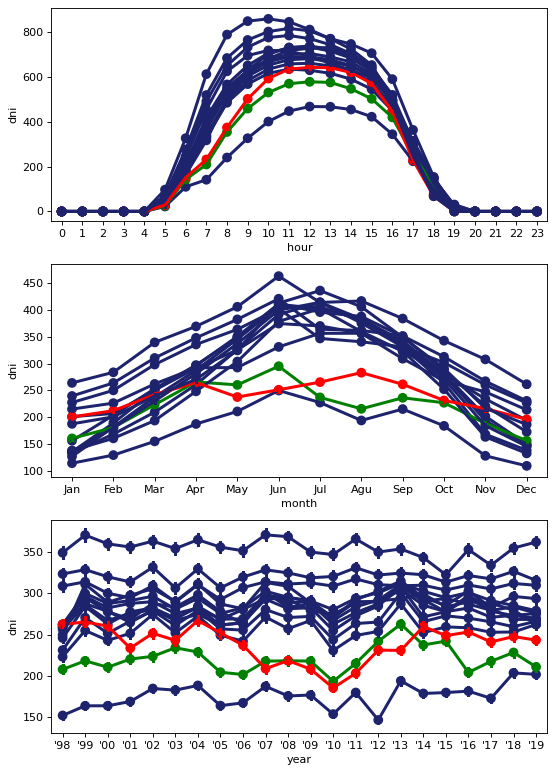

In [ ]:
temporal = Temporal()
for key in locs.keys():
    df = pd.read_csv(f'{data_dir}processed/{key}.zip')

    if key == 'San Francisco':
        c = 'g'
    elif key == 'San Diego':
        c = 'r'
    else:
        c = colors['BLUE']
        
    temporal.plot(df, c=c)

Intuitively, `DNI` should be inversely proportional to latitude. However, looking at the figure we see that <font color='red'>San Diego</font> and <font color='green'>San Francisco</font> seem to debunk this hypothesis. We will try and explain the causality of this in the latter part of the Location Correlation Analysis.

# 3. Location Correlation Analysis

### Mathematical Background

Linear correlation describes the strength of the linear dependency between two variables. It is described in terms of a linear correlation coefficient $R$, which ranges from $-1$ to $1$. Loosely speaking, $R=-1$ describes perfect inverse linear dependency, $R=0$ no linear dependency and $R=1$ perfect proportional linear dependency.

More formally, we define R for two variables x and y as
$$
R = \frac{\sum (x_i  - \bar{x})(y_i-\bar{y})}{\sqrt{\sum (x_i  - \bar{x})^2}\sqrt{\sum (y_i  - \bar{y})^2}}
$$
where $\bar{x}$ denotes mean value (James et al. 2013).

Now, if our data is normally distributed it should be homoscedastic, i.e. a sequence of with should have a constant variance. If however, the variance is different across the elements of the sequence, we say that the vector is heteroscedastic. Visually, this is seen by the scatter points from the sequence diverging (or converging) around the linear regression line (James et al. 2013). We will demonstrate both homo- and heteroscedasticity with an example from our data later on in this section.


**a) How correlated are different measurement sites with each other?**

We start by creating a simple correlation matrix, with a linear correlation for `DNI` values for each location, averaged over each day over the entire 22 years for computational efficiency and noise reduction.

In [ ]:
# Create a df with mean values for each month for each year for each location
df_summed = pd.DataFrame()
indices = [0, 1, 2, 3, 4, 6]
for i, key in enumerate(locs.keys()):
    df = pd.read_csv(f'{data_dir}processed/{key}.zip',
                     usecols=indices)
    df['datetime'] = pd.to_datetime(df.iloc[:, 0:5])
    df.drop(df.columns[0:5], axis=1, inplace=True)
    df = df.groupby(df['datetime'].dt.to_period('D')).mean()
    df_summed[key] = df.dni

# Create the correlation matrix
df_corr = df_summed.corr()
pd.set_option('display.width', 200)  # To print all columns in same line
pd.set_option('display.max_columns', None)  # To print all columns in same line
print('Correlation Matrix')
print(round(df_corr, 2))

Correlation Matrix
                 Chico  Fresno  Bakersfield  Los Angeles  Eureka  Merced  San Francisco  Redding  Sacramento  San Luis Obispo  San Diego  Palm Springs  Mojave  Dorrington  Sequoia
Chico             1.00    0.76         0.66         0.47    0.58    0.83           0.55     0.93        0.94             0.65       0.21          0.43    0.49        0.84     0.54
Fresno            0.76    1.00         0.88         0.61    0.40    0.94           0.46     0.68        0.82             0.78       0.35          0.60    0.67        0.80     0.74
Bakersfield       0.66    0.88         1.00         0.67    0.33    0.81           0.36     0.59        0.71             0.73       0.42          0.67    0.72        0.71     0.75
Los Angeles       0.47    0.61         0.67         1.00    0.21    0.57           0.34     0.41        0.51             0.72       0.68          0.63    0.65        0.55     0.63
Eureka            0.58    0.40         0.33         0.21    1.00    0.45         

**b) How does the correlation change with distance?**

First we calculate the distance between every location and display in a matrix. We measure the distance between two points on the surface of a sphere. We will be calculating both the L-2 and L-1 (Manhattan) distance, we will explain why later on.

In [ ]:
class DistCalc():
    """Class created for reproducibility and multiple calls to dataframe"""

    def __init__(self):
        N = len(locs)
        self.df = pd.DataFrame(np.zeros((N, N))) 

    def calc_dist(self, coordsA, coordsB):
        """For convenience if
        also using horizontal & vertical distances
        """

        dist = geopy.distance.geodesic((coordsA),
                                       (coordsB))
        self.df.iloc[i, j] = round(dist.kilometers)
        self.df.rename(columns={i: keyA},
                       index={j: keyB},
                       inplace=True)
    
dist_L2 = DistCalc()
dist_vert = DistCalc()
dist_hori = DistCalc()
for i, (keyA, valA) in enumerate(locs.items()):
    for j, (keyB, valB) in enumerate(locs.items()):
        # [::-1] b/c 'geodesic' reads lat/lon but ours is lon/lat
        dist_L2.calc_dist(valA[::-1],  valB[::-1])
        dist_vert.calc_dist((valA[1], 0), (valB[1], 0))
        # Strictly speaking, dist between longitude lines is a function
        # of latitude, but we approximate lat as 37
        dist_hori.calc_dist((37, valA[0]), (37, valB[0]))

dist_L1 = dist_vert.df.add(dist_hori.df, fill_value=0)
dist_L2 = dist_L2.df
print('L1 [km]')
print(dist_L1)
print('L2 [km]')
print(dist_L2)

L1 [km]
                  Chico  Fresno  Bakersfield  Los Angeles  Eureka  Merced  San Francisco  Redding  Sacramento  San Luis Obispo  San Diego  Palm Springs  Mojave  Dorrington  Sequoia
Chico               0.0   515.0        733.0        947.0   327.0   388.0          283.0    143.0       157.0            596.0     1186.0        1127.0  1019.0       294.0    690.0
Fresno            515.0     0.0        219.0        432.0   841.0   126.0          346.0    657.0       357.0            238.0      672.0         612.0   505.0       221.0    176.0
Bakersfield       733.0   219.0          0.0        214.0  1060.0   345.0          563.0    876.0       576.0            155.0      453.0         394.0   286.0       438.0    171.0
Los Angeles       947.0   432.0        214.0          0.0  1273.0   558.0          778.0   1091.0       790.0            352.0      239.0         180.0   241.0       653.0    257.0
Eureka            327.0   841.0       1060.0       1273.0     0.0   715.0          496.

We now plot the correlation as a function of distance

Text(0.5, 1.0, 'Distance Correlation')

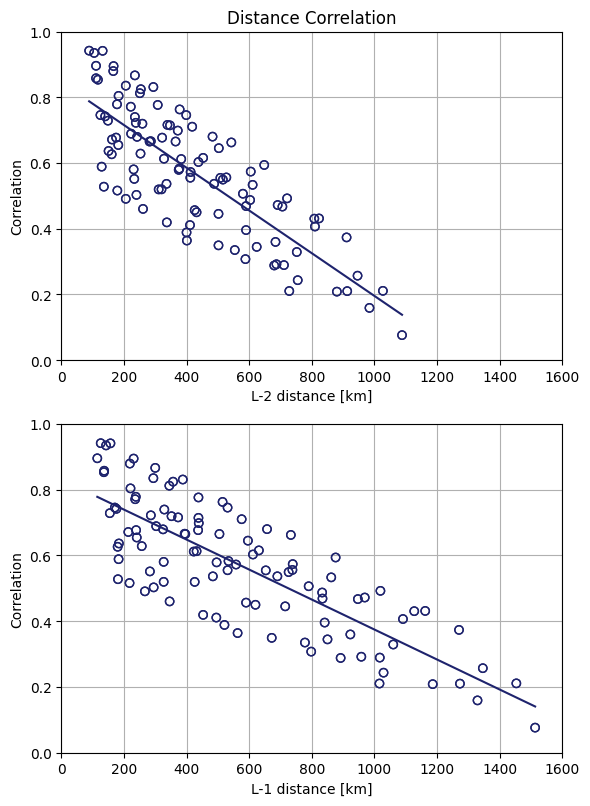

In [ ]:
plot_size(6, 8, 100)
fig, (ax1, ax2) = plt.subplots(2)
N = len(locs)
seaside = ['Los Angeles', 'Eureka', 'San Diego',
           'San Francisco', 'San Luis Obispo']

class DistCorr():
    """Creates a distance correlation plot + regression"""

    def __init__(self, df, ax, L, const_color=True):
        self.df = df
        self.xy = np.zeros((N*(N-1), 2))  # -1 b/c we omit the diagonals
        self.k = 0
        self.const_color = const_color

        self.ax = ax
        self.ax.set_xlim([0, 1600])
        self.ax.set_ylim([0, 1])
        self.ax.grid(zorder=1)
        self.ax.set_ylabel('Correlation')
        self.ax.set_xlabel(f'L-{L} distance [km]')

    def corr_dist(self, i, j):
        """Calculates the distance correlation"""

        c = colors['BLUE'] if self.const_color else self.c_col(i, j)

        self.xy[self.k, :] = [self.df.iloc[i,j], df_corr.iloc[i,j]]
        self.ax.scatter(self.df.iloc[i,j], df_corr.iloc[i,j],
                       facecolors='none', edgecolors=c, zorder=3)
        self.k += 1
    
    def c_col(self, i, j):
        """Determines scatter point color based on proximity to sea"""

        c = colors['BLUE']
        if any(self.df.columns[i] == sea for sea in seaside):
            if any(self.df.index[j] == sea for sea in seaside):
                c = 'r'
            else:
                c = 'g'
        elif any(self.df.columns[j] == sea for sea in seaside):
            if any(self.df.index[i] == sea for sea in seaside):
                c = 'r'
            else:
                c = 'g'        
        else:
            pass
        
        return c

    def lin_regr(self):
        """Executes linear regression"""

        x = self.xy[:, 0]
        y = self.xy[:, 1]
        p = np.polyfit(x, y, deg=1)
        x_r = np.linspace(min(x), max(x))
        y_r = np.polyval(p, x_r)
        self.ax.plot(x_r, y_r, c=colors['BLUE'], zorder=2)
    
    def get_xy(self):
        """Creates a dataframe for model diagnostics"""

        self.xy = self.xy[self.xy[:, 0].argsort()]  # Sort by the first column (ascending)
        self.xy = pd.DataFrame(self.xy, columns=['distance', 'correlation'])
        return self.xy

dc_L2 = DistCorr(dist_L2, ax1, 2)
dc_L1 = DistCorr(dist_L1, ax2, 1)

for i in range(N):
    for j in range(N):
        if i != j: # We don't plot the diagonal values
            dc_L2.corr_dist(i, j)
            dc_L1.corr_dist(i, j)

dc_L2.lin_regr()
dc_L1.lin_regr()
xy_L2 = dc_L2.get_xy()
xy_L1 = dc_L1.get_xy()

plt.tight_layout()
ax1.set_title('Distance Correlation')

The relationship for both methods looks reasonably linear. The L-2 distance looks heteroscedastic and the L-1 distance homoscedastic. We hypothesize that the heteroscedasticity is because of the different irradiance patterns for seaside locations. Let's look at whether the distribution of <font color='green'>seaside-inland</font> and <font color='red'>seaside-seaside</font> correlation pairs are different from <font color='blue'>inland-inland</font> correlation pairs.

Text(0.5, 1.0, 'Distance Correlation')

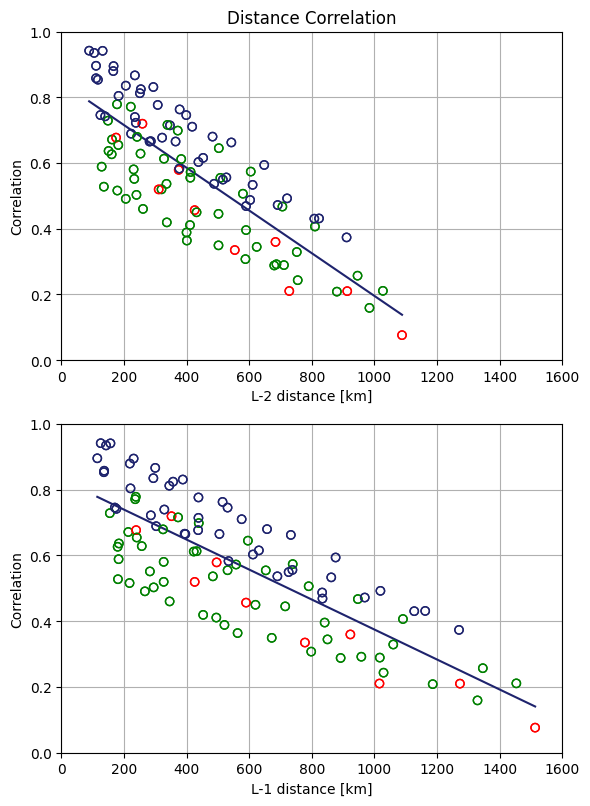

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)

dc_L2 = DistCorr(dist_L2, ax1, 2, False)
dc_L1 = DistCorr(dist_L1, ax2, 1, False)

for i in range(N):
    for j in range(N):
        if i != j: # We don't plot the diagonal values
            dc_L2.corr_dist(i, j)
            dc_L1.corr_dist(i, j)

dc_L2.lin_regr()
dc_L1.lin_regr()

plt.tight_layout()
ax1.set_title('Distance Correlation')

The figure reveals that the <font color='green'>seaside-inland</font> and <font color='red'>seaside-seaside</font> are less linearly correlated than <font color='blue'>inland-inland</font> correlation pairs, corroborating our hypothesis.


Let's create a linear model to properly quantify the relationship between correlation and distance. This is where R admittedly reigns superior to Python in terms of simplicity, so we're basically going to recreate the R diagnosic plots. The next cell's code is adapted and modified from [here](https://bit.ly/3231wrB).

                            OLS Regression Results                            
Dep. Variable:            correlation   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     397.0
Date:                Mon, 12 Apr 2021   Prob (F-statistic):           4.09e-50
Time:                        06:15:48   Log-Likelihood:                 158.87
No. Observations:                 210   AIC:                            -313.7
Df Residuals:                     208   BIC:                            -307.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8455      0.016     53.257      0.0

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


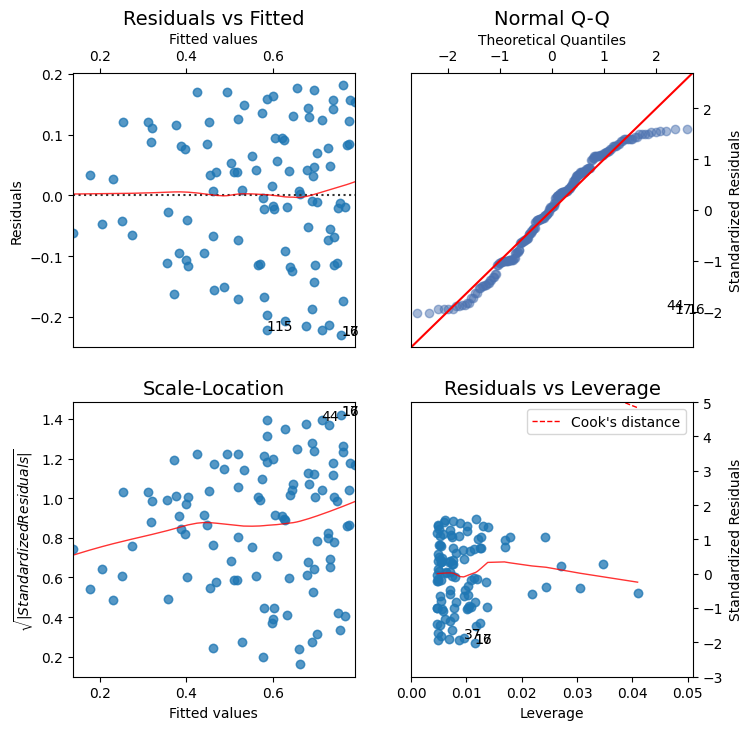

In [ ]:
plot_size(8, 8, 100)

class DiagnosticPlots:
    """Reproduces the 4 base plots of an OLS model in R.
    
    Original code from here: https://bit.ly/3a4YGH1, with modifications
    by gt2447.
    """

    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.fig, self.ax = plt.subplots(2, 2)
        self.set_properties()

        self.model()
        self.resid_vs_fitted()
        self.qq_plot()
        self.heteroscedasticity()
        self.resid_vs_leverage()

    def model(self):
        """Creates a linear regression model"""

        self.model = sm.OLS(self.y, sm.add_constant(self.X)).fit()

        # create df from X, y for easier plot handling
        self.df = pd.concat([self.X, self.y], axis=1)

        # Getting miscallaneous properties
        self.modelted_y = self.model.fittedvalues
        self.model_residuals = self.model.resid
        self.model_norm_residuals = self.model.get_influence().resid_studentized_internal
        self.model_norm_residuals_abs_sqrt = np.sqrt(
            np.abs(self.model_norm_residuals))
        self.model_abs_resid = np.abs(self.model_residuals)
        self.model_leverage = self.model.get_influence().hat_matrix_diag
        self.model_cooks = self.model.get_influence().cooks_distance[0]

        print(self.model.summary())

    def graph(self, formula, x_range, label=None):
        """Helper function for plotting cook's distance lines"""

        x = x_range
        y = formula(x)
        plt.plot(x, y, label=label, lw=1, ls='--', color='red')

    def resid_vs_fitted(self):
        sns.residplot(self.modelted_y, self.df.columns[-1], data=self.df,
                      ax=self.ax[0, 0],
                      lowess=True,
                      scatter_kws={'alpha': 0.5},
                      line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

        # Annotations
        abs_resid = self.model_abs_resid.sort_values(ascending=False)
        abs_resid_top_3 = abs_resid[:3]
        for i in abs_resid_top_3.index:
            self.ax[0, 0].annotate(i,
                                   xy=(self.modelted_y[i],
                                       self.model_residuals[i]))

    def qq_plot(self):
        QQ = ProbPlot(self.model_norm_residuals)
        QQ.qqplot(line='45',
                  alpha=0.5,
                  color='#4C72B0',
                  lw=1,
                  ax=self.ax[0, 1])

        # Annotations
        abs_norm_resid = np.flip(np.argsort(
            np.abs(self.model_norm_residuals)), 0)
        self.abs_norm_resid_top_3 = abs_norm_resid[:3]
        for r, i in enumerate(self.abs_norm_resid_top_3):
            self.ax[0, 1].annotate(i,
                                   xy=(np.flip(QQ.theoretical_quantiles,
                                               0)[r],
                                       self.model_norm_residuals[i]))

    def heteroscedasticity(self):
        self.ax[1, 0].scatter(self.modelted_y,
                              self.model_norm_residuals_abs_sqrt,
                              alpha=0.5)
        sns.regplot(self.modelted_y,
                    self.model_norm_residuals_abs_sqrt,
                    ax=self.ax[1, 0],
                    scatter=False,
                    ci=False,
                    lowess=True,
                    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

        # Annotations
        abs_sq_norm_resid = np.flip(
            np.argsort(self.model_norm_residuals_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in self.abs_norm_resid_top_3:
            self.ax[1, 0].annotate(i,
                                   xy=(self.modelted_y[i],
                                       self.model_norm_residuals_abs_sqrt[i]))

    def resid_vs_leverage(self):
        self.ax[1, 1].scatter(self.model_leverage,
                              self.model_norm_residuals, alpha=0.5)
        sns.regplot(self.model_leverage, self.model_norm_residuals,
                    ax=self.ax[1, 1],
                    scatter=False,
                    ci=False,
                    lowess=True,
                    line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

        # Annotations
        leverage_top_3 = np.flip(np.argsort(self.model_cooks), 0)[:3]
        for i in leverage_top_3:
            self.ax[1, 1].annotate(i,
                                   xy=(self.model_leverage[i],
                                       self.model_norm_residuals[i]))

        p = len(self.model.params)  # number of model parameters
        self.graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x),
                   np.linspace(0.001, max(self.model_leverage), 50),
                   'Cook\'s distance')  # 0.5 line
        self.graph(lambda x: np.sqrt((1 * p * (1 - x)) / x),
                   np.linspace(0.001, max(self.model_leverage), 50))  # 1 line
        self.ax[1, 1].legend(loc='upper right')

    def set_properties(self):
        self.ax[0, 0].set_title('Residuals vs Fitted')
        self.ax[0, 0].set_xlabel('Fitted values')
        self.ax[0, 0].set_ylabel('Residuals')
        self.ax[0, 0].xaxis.tick_top()
        self.ax[0, 0].xaxis.set_label_position('top')

        self.ax[0, 1].set_title('Normal Q-Q')
        self.ax[0, 1].set_xlabel('Theoretical Quantiles')
        self.ax[0, 1].set_ylabel('Standardized Residuals')
        self.ax[0, 1].yaxis.tick_right()
        self.ax[0, 1].xaxis.tick_top()
        self.ax[0, 1].xaxis.set_label_position('top')
        self.ax[0, 1].yaxis.set_label_position('right')

        self.ax[1, 0].set_ylabel('Std. Residuals')
        self.ax[1, 0].set_title('Scale-Location')
        self.ax[1, 0].set_xlabel('Fitted values')
        self.ax[1, 0].set_ylabel('$\sqrt{|Standardized Residuals|}$')

        self.ax[1, 1].yaxis.tick_right()
        self.ax[1, 1].set_xlabel('Leverage')
        self.ax[1, 1].set_ylabel('Std. Residuals')
        self.ax[1, 1].yaxis.set_label_position('right')
        self.ax[1, 1].set_xlim(0, max(self.model_leverage)+0.01)
        self.ax[1, 1].set_ylim(-3, 5)
        self.ax[1, 1].set_title('Residuals vs Leverage')
    
    
DiagnosticPlots(xy_L2.distance, xy_L2.correlation)

The four diagnostic plots indicate the following:

- *Residuals vs. Fitted* demonstrates a relatively linear relationship, as the red line is pretty horizontal

- The *QQ-plot* behaves nicely around the middle, but deviates from a straight line at the ends, indicating imperfect normal distribution

- The heteroscedasticity we've hinted at is finally corroborated in the *Scale-Location* plot (and the Residuals vs. Fitted)

- From *Residuals vs. Leverage* we infer that no outliers are negatively affecting our model.

Following our earlier revelation that distance to sea seems to be a factor in modeling `DNI`, we are now going to look at their relationship with latitude.

We start by plotting location as a function of `DNI`.

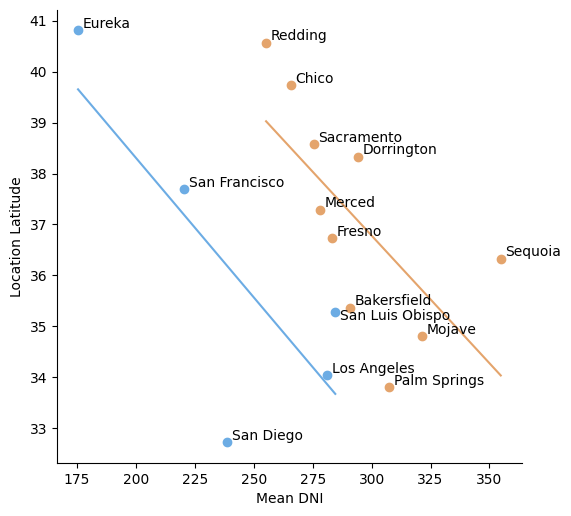

In [ ]:
def lin_regr(x, y, c):
    p = np.polyfit(x, y, deg=1)
    x_r = np.linspace(min(x), max(x))
    y_r = np.polyval(p, x_r)
    ax.plot(x_r, y_r, c=c)

plot_size(6, 6, 100)
fig, ax = plt.subplots()
df_lat = pd.DataFrame(np.zeros((len(locs), 4)),
                    columns=['lat', 'dni', 'loc', 'sea'])
seaside = ['Los Angeles', 'Eureka', 'San Diego',
           'San Francisco', 'San Luis Obispo']
for i, (key, val) in enumerate(locs.items()):
    df = pd.read_csv(f'{data_dir}processed/{key}.zip')
    df_lat.iloc[i, 0] = val[1]  # val[1] is latitude
    df_lat.iloc[i, 1] = df.dni.mean()
    df_lat.iloc[i, 2] = key  # key is name of location
    df_lat.iloc[i, 3] = True if any([key==sea for sea in seaside]) else False

    c = colors['blue'] if df_lat.sea[i] else colors['orange']
    ax.scatter(df_lat.dni[i], df_lat.lat[i], c=c)
    # Prevent overlapping
    v_offset = -0.15 if key=='San Luis Obispo' else 0.05
    ax.text(df_lat.dni[i] + 2, df_lat.lat[i] + v_offset, key)

df_inland = df_lat[df_lat.sea == False]
df_sea = df_lat[df_lat.sea == True]
lin_regr(df_inland.dni, df_inland.lat, colors['orange'])
lin_regr(df_sea.dni, df_sea.lat, colors['blue'])

ax.set_xlabel('Mean DNI')
ax.set_ylabel('Location Latitude')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Ths figure further demonstrates that the five coastal cities (blue) receive less insolation, especially Eureka, San Francisco and San Diego; LA and San Luis Obispo to a lesser extent. The two regression lines are drawn to underline the different behavior of the two classes.

Let's see how well the irradiance follows the equation

$$
I = \beta_2 r + \beta_1 \varphi + \beta_0
$$

where $I$ is `DNI` over the sampling period, $r$ is distance to shore, $\varphi$ is latitude and $\beta_i$ denotes multivariate linear regression coefficients.

First we calculate the distance to shore

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.


Text(134.54858267639315, 0.5, 'Latitude')

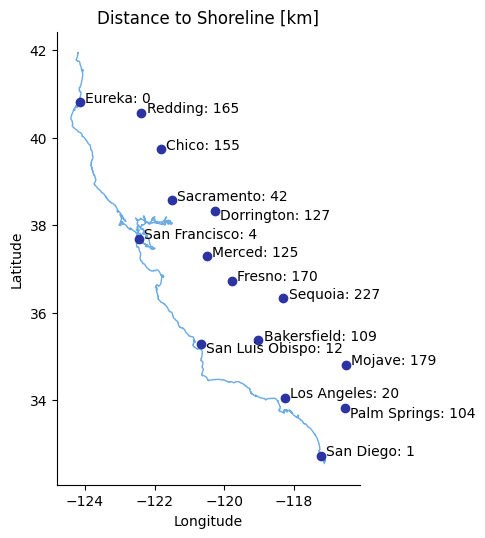

In [ ]:
fig, ax = plt.subplots()

gdf_shore = gpd.read_file(f'{data_dir}geospatial/coastl_usa.shp')
gdf_shore = gdf_shore.to_crs(crs=crs)
gdf_shore.plot(ax=ax, cmap=cmap, linewidth=1, edgecolor='white', zorder=-1)
r = np.zeros(len(locs))
for i, (key, val) in enumerate(locs.items()):
    point = gpd.GeoSeries([Point(val[0],val[1])])
    point.crs = crs
    dist = gdf_shore.distance(point)
    r[i] = round(dist[0] * 100)
    ax.scatter(val[0], val[1], c=colors['Blue'])
    v_offset = -0.2 if any([key==lap for lap in overlap]) else 0
    r_text = np.array2string(r[i])
    r_text = r_text.split(".")[0]
    ax.text(val[0] + 0.15, val[1] + v_offset, f'{key}: {r_text}')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Distance to Shoreline [km]')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

There's an inherent problem there. Because our algorithm simply looks for the shortest distance to shoreline, Sacramento and Dorrington are calculated as being way closer to sea than they actually are because of San Francisco Bay. We will be compensating for that manually, as modifying shapefiles is a cumbersome GIS-endeavour. 

Now let's perform multivariate Linear Regression

In [ ]:
regr = sklearn.linear_model.LinearRegression()
df_lat['r'] = r

# Manually changing approximate correct values for Sacramento
# and Dorrington
df_lat.iloc[8, -1] = 100
df_lat.iloc[13, -1] = 220

regr.fit(df_lat[['lat', 'r']], df_lat.dni)
B0 = regr.intercept_
B1, B2 = regr.coef_
I = B2 * df_lat.r + B1 * df_lat.lat + B0

Let's plot the regression results to get a qualitative feel for it

Text(0.5, 1.0, 'DNI vs. Lat & Distance to Sea')

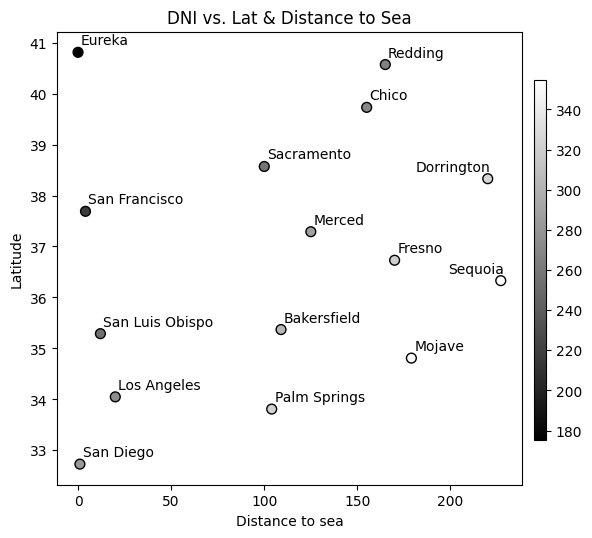

In [ ]:
fig, ax = plt.subplots()
ax.scatter(df_lat.r, df_lat.lat, c=I, cmap='gray', edgecolor='k', s=50)
ax.set_xlabel('Distance to sea')
ax.set_ylabel('Latitude')
sm = plt.cm.ScalarMappable(cmap='gray',
                           norm=plt.Normalize(vmin=min(df_lat.dni),
                                              vmax=max(df_lat.dni)))
ax2 = fig.add_axes([0.92, 0.20, 0.02, 0.6])
fig.colorbar(sm, cax=ax2, orientation='vertical')
move = ['Dorrington', 'Sequoia']
for i in range(len(df_lat)):
    ha = 'right' if any(df_lat.loc[i,'loc'] == m for m in move) else 'left'
    ax.text(df_lat.loc[i, 'r'] + 1.5,
            df_lat.loc[i, 'lat'] + 0.15,
            df_lat.loc[i, 'loc'],
            ha=ha)
ax.set_aspect('auto')
ax.set_title('DNI vs. Lat & Distance to Sea')

It seems as if these two variables do a good job of modeling mean DNI, but we need to have a quantitative look at the model results.

In [ ]:
model = sm.OLS(df_lat.dni, df_lat[['lat']]).fit()
print('SINGLE VARIABLE - LAT')
print(model.summary())

SINGLE VARIABLE - LAT
                                 OLS Regression Results                                
Dep. Variable:                    dni   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                              396.5
Date:                Tue, 13 Apr 2021   Prob (F-statistic):                    1.14e-11
Time:                        17:03:51   Log-Likelihood:                         -80.367
No. Observations:                  15   AIC:                                      162.7
Df Residuals:                      14   BIC:                                      163.4
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


In [ ]:
model = sm.OLS(df_lat.dni, df_lat[['lat', 'r']]).fit()
print('TWO VARIABLES - LAT & DISTANCE TO SEA')
print(model.summary())

TWO VARIABLES - LAT & DISTANCE TO SEA
                                 OLS Regression Results                                
Dep. Variable:                    dni   R-squared (uncentered):                   0.976
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              260.1
Date:                Tue, 13 Apr 2021   Prob (F-statistic):                    3.28e-11
Time:                        17:03:55   Log-Likelihood:                         -77.850
No. Observations:                  15   AIC:                                      159.7
Df Residuals:                      13   BIC:                                      161.1
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
---

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


We see that the F-statistic for the latitude-only model is 396.5, higher than
the bivariate model's F-statistic of 260. The trend follows for the AIC values. Though the adjusted R-squared values are similar for both at .97,
we see that the additional variable does not help our model. That doesn't necessarily reject our hypothesis, as it only means that seaside proximity doesn't improve the model, not that there isn't any causality (James et al. 2013).

## 4. Long-Term Forecast

**Establish a forecast model and predict the future trend of your dataset across different locs. You should use 2/3 of the time duration in your data set to train your model, and test the result using the rest 1/3 dataset.**

In [ ]:
import pandas as pd
from sklearn.datasets import load_iris
!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install eli5

     |████████████████████████████████| 40kB 4.3MB/s 
  Created wheel for factor-analyzer: filename=factor_analyzer-0.3.2-cp37-none-any.whl size=40383 sha256=4b35b8f235b75ae6ddfc6a93c0296f01aacf25f60dde567ac21ed574592c5f17
  Stored in directory: /root/.cache/pip/wheels/4a/d0/57/f1330cb9c80e82d8d05391c74c94ed61ce3f03bf6157f3d6db
Successfully built factor-analyzer
     |████████████████████████████████| 112kB 9.4MB/s 


In [ ]:
import pandas as pd
from sklearn.datasets import load_iris
!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
import pandas as pd
from numpy import arange
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold

We will begin the long-term forecast model by plotting a correlation matrix of the variables. This is meant to show us the relationship between one variable to another and therefore give us information on potential collinearity in our overall model. 

Each graph is its own simple linear regression. It is formed be the Ordinary Least Squares method which takes a compilation of the function

yi=β0+β1xi+ϵi, i=1,2...n

and uses n examples of it to form the following:

∑yi=nβ0+β1∑xi+∑ϵ

To minimize the sum of the squared rediduals we use 

C=(β0+β1x1−y1)^2+(β0+β1x2−y2)^2+...+(β0+β1xn−yn)^2

where we minimize C by taking partial derivatives with respect to B1 and set the results to 0 to get 

∑xiyi=∑xiβ0+β1∑x2i 

Solving for β0 and β1 we now get:

β0=((∑x2i)(∑yi)−(∑xi)(∑xiyi))/n∑x2i−(∑xi)2β1= (n(∑xiyi)−(∑xi)(∑yi))/n∑xi^2−(∑xi)^2

This method iterated over multiple variables allows us to see the lines in the correlation matrix seen below.

Across the diagnoal we see kernel density estimations which are a non-parametric way of estamating the probability densit function of a random variable.

If we take an independent and identicaly distributed sample, we can greate a density function f with the following formula:

f^n(x)=(1/nh)n∑i=1K((Xi−x)/h)


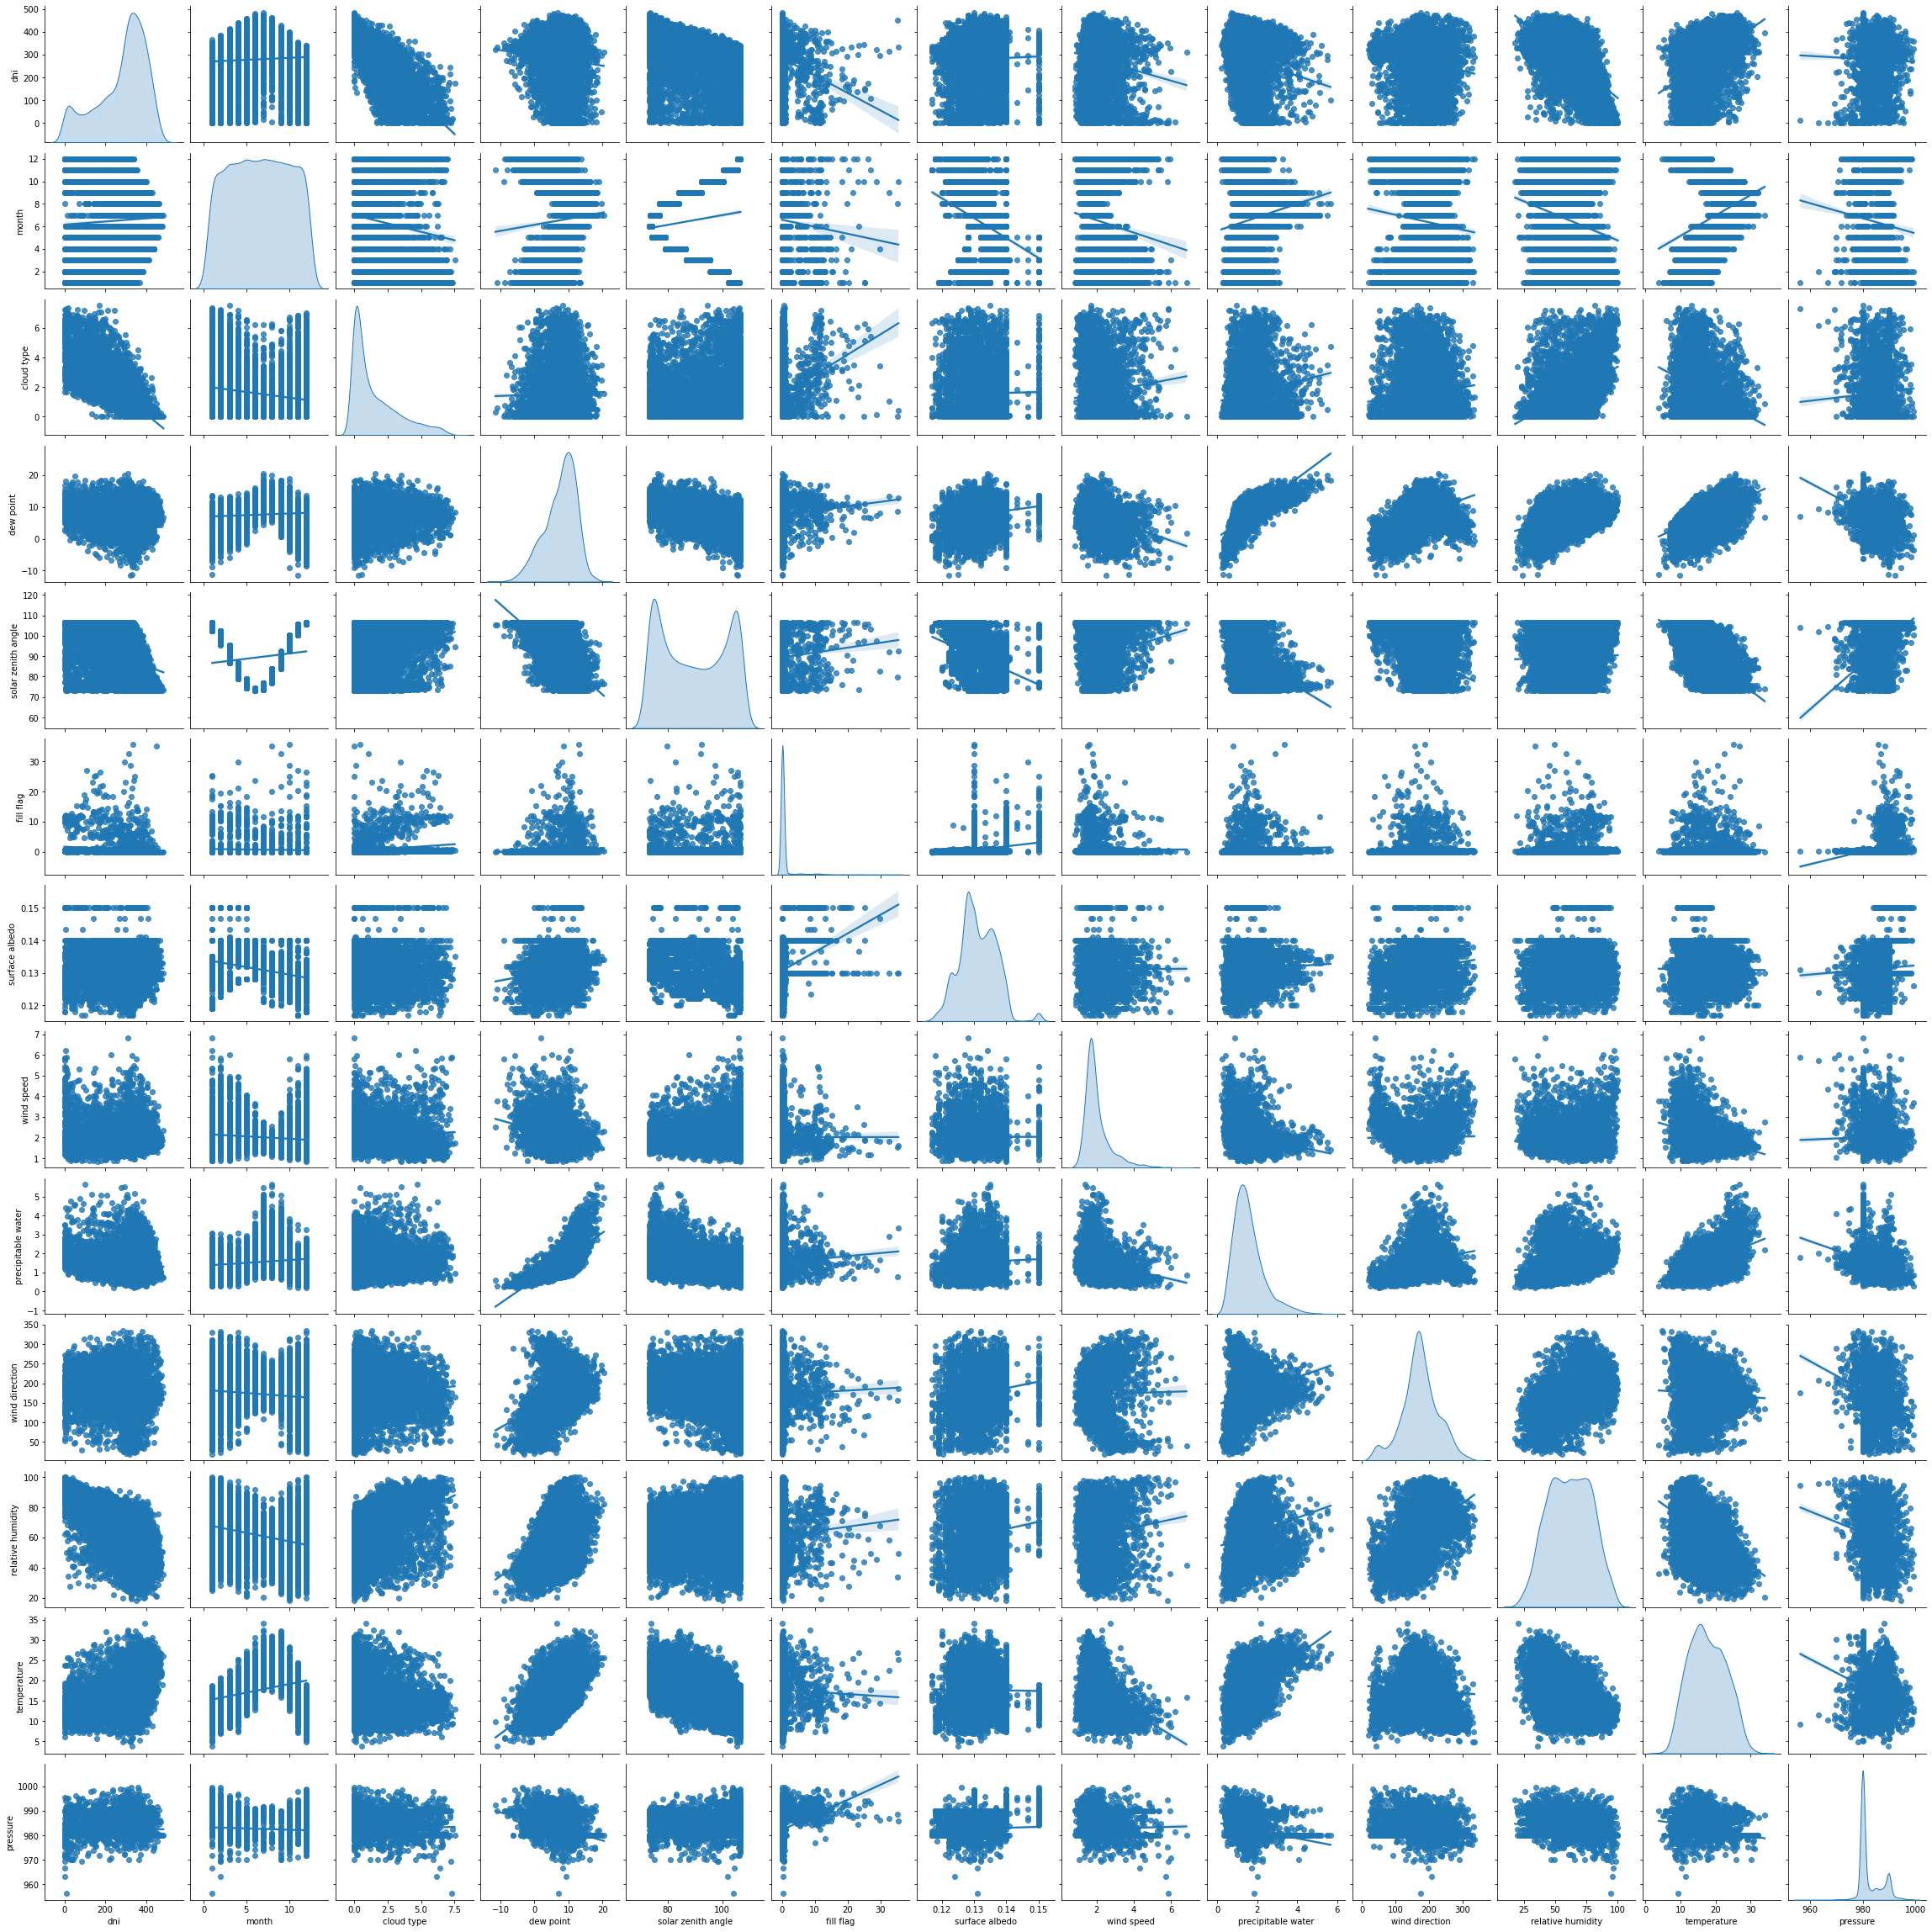

In [ ]:

train_dataset = x_train.copy()
train_dataset.insert(0, "dni", y_train)
_ = sns.pairplot(train_dataset, kind='reg', diag_kind='kde')

After our simple linear regression, we then use a multivariate linear regression to see the correlation between many dependent variables and our independent variable, DNI. 

We begin with:

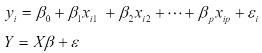

Where Y is a vector n*1 which is the predicted vector

X is a matrix n*(p+1) which is a predictor matrix

β is a vector (p+1)*1 which is a parameter or coefficient vector

ϵ is a vector n*1 which is a residual or error vector

The coefficients for each variable are expressed below and we see several factors with low coefficients, so they have low impact on the model. We also weeded out any variables with high p-values as they are not good fits for the data.

The t-value for any score is calculated with the following equation: 

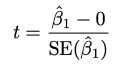

and allows the hypothesis to be rejected, should the corresponding p-value be less than 5%, for this instance.



                         Coeff
month                -3.063503
cloud type          -36.853349
dew point            11.268990
solar zenith angle   -1.554510
fill flag            -3.097564
surface albedo      431.341030
wind speed           -3.490964
precipitable water  -26.602912
wind direction        0.099309
relative humidity    -5.163081
temperature          -7.906691
pressure             -0.092001
44.54283540812047
3575.7682226199454
59.79772757070243
                                 OLS Regression Results                                
Dep. Variable:                    dni   R-squared (uncentered):                   0.965
Model:                            OLS   Adj. R-squared (uncentered):              0.965
Method:                 Least Squares   F-statistic:                          1.234e+04
Date:                Tue, 13 Apr 2021   Prob (F-statistic):                        0.00
Time:                        14:11:14   Log-Likelihood:                         -29395.
No. Observatio

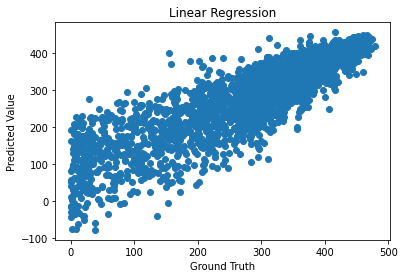

In [ ]:
loc = 'Los Angeles'
df = pd.read_csv(f'{data_dir}processed/{loc}.zip')
df['datetime'] = pd.to_datetime(df.iloc[:, 0:5])
df = df.groupby(df['datetime'].dt.to_period('d')).mean()
y = df['dni']
dropping = ['year', 'day', 'hour', 'minute', 'dhi', 'dni', 'ghi', 'clearsky dhi', 'clearsky dni',
            'clearsky ghi', 'global horizontal uv irradiance (280-400nm)',
       'global horizontal uv irradiance (295-385nm)']
x = df.drop(dropping, axis=1)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.33)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)
print(pd.DataFrame(model.coef_, x.columns, columns = ['Coeff']))

y_pred = model.predict(x_test)
plt.scatter(y_test, y_pred)
plt.xlabel("Ground Truth")
plt.ylabel("Predicted Value")
plt.title("Linear Regression")

from sklearn import metrics

print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

model = sm.OLS(y_train, x_train).fit()
print(model.summary())

0.7575459108463302


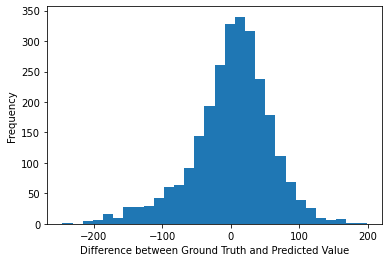

In [ ]:
plt.hist(y_test - y_pred, bins=30)
plt.ylabel("Frequency")
plt.xlabel("Difference between Ground Truth and Predicted Value")
print(model.score(x_test, y_test))

The two graphs we see above include a graph of predicted value vs true value and the distribution of the frequency of the difference between true value and predicted value.

The predicted values are calculated based on the inputs in our test data along with the equation of our multiple linear regression line. The ground truth is already contained in our test data.

We also use several diagnostic tools to assess the fit of our model. This includes the mean absolute error (MAE), the mean squared error (MSE), the root mean squared error (RMSE), and the accuracy of our model.

The mean absolute error is calculated by dividing the difference between predicted and true values (SAE) by the number of samples or:

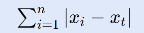

This would then be divided by n

The MSE is calculated by squaring the difference of the predicted value and the observed value, and dividing by n. This penalizes any big errors in the data:

image.png

The RMSE is then just the square root of these values. Its equation is as follows:

image.png

Finally, the accuracy of our model is computed through the following equation:

1 - (|Predicted - Observed|/Observed)

This tells us how closely our data comes within our prediction.

LassoCV(alphas=[1, 1.05, 1.15, 1.2, 1.25], copy_X=True, cv=5, eps=0.001,
        fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=None,
        normalize=False, positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)
Alpha:1.15, R2:0.762, MSE:3418.56, RMSE:58.47
43.75096379028136


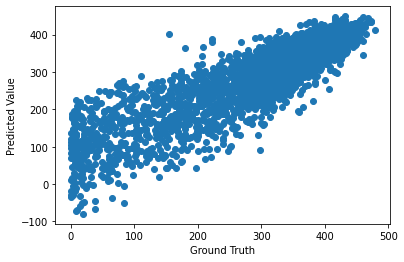

In [ ]:
from sklearn.linear_model import Lasso
#Lasso Regression
df = pd.read_csv(f'{data_dir}processed/{loc}.zip')
df['datetime'] = pd.to_datetime(df.iloc[:, 0:5])
df = df.groupby(df['datetime'].dt.to_period('d')).mean()
y = df['dni']
dropping = ['year', 'day', 'hour', 'minute', 'dhi', 'dni', 'ghi', 'clearsky dhi', 'clearsky dni',
            'clearsky ghi', 'global horizontal uv irradiance (280-400nm)',
       'global horizontal uv irradiance (295-385nm)']
x = df.drop(dropping, axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

alphas = [1, 1.05, 1.15, 1.2, 1.25]
lassocv = LassoCV(alphas=alphas, cv=5).fit(x,y)
print(lassocv)
LassoCV(alphas=[0.1, 0.3, 0.5, 0.8, 1], copy_X=True, cv=5, eps=0.001,
    fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=1,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False) 

score = lassocv.score(x,y)
y_pred = lassocv.predict(x_test)
mse = metrics.mean_squared_error(y_test,y_pred)
print("Alpha:{0:.2f}, R2:{1:.3f}, MSE:{2:.2f}, RMSE:{3:.2f}"
    .format(lassocv.alpha_, score, mse, np.sqrt(mse)))

plt.scatter(y_test, y_pred)
plt.xlabel("Ground Truth")
plt.ylabel("Predicted Value")
print(metrics.mean_absolute_error(y_test, y_pred))

For this model, we begin with a Lasso which is a method used to fit a regression model when we know that multicollinearity is present in our data, which we saw in our earlier table. It tries to find coefficient estimates that minimize the sum of squared residuals, defined by the following equation

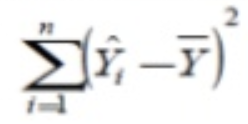

and produce the MSE through optimization of a shrinkage penalty:


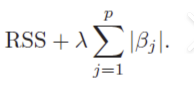

After optimizing the amount of predictor variables to minimize the MSE, we calculate our multiple linear regression and test stastic using the same methods we used in our previous example.

In [ ]:
from sklearn.linear_model import Lasso

#Lasso Regression
df = pd.read_csv(f'{data_dir}processed/{loc}.zip')
df['datetime'] = pd.to_datetime(df.iloc[:, 0:5])
df = df.groupby(df['datetime'].dt.to_period('d')).mean()
y = df['dni']
dropping = ['year', 'day', 'hour', 'minute', 'dhi', 'dni', 'ghi', 'clearsky dhi', 'clearsky dni',
            'clearsky ghi', 'global horizontal uv irradiance (280-400nm)',
       'global horizontal uv irradiance (295-385nm)']
x = df.drop(dropping, axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
lasso = Lasso(alpha=1.5)

# Fit the Lasso model
lasso.fit(x_train, y_train)
# Create the model score
print(lasso.score(x_test, y_test))

print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

0.7618319579832704
123.76694169632405
25155.377485188113
158.6044686797573


(array([  1.,   4.,   4.,  12.,  13.,  15.,  15.,  31.,  33.,  35.,  34.,
         62.,  68., 115., 134., 208., 275., 286., 294., 262., 245., 167.,
        126.,  78.,  55.,  31.,  19.,   9.,   9.,  10.]),
 array([-233.21501879, -219.90186567, -206.58871256, -193.27555944,
        -179.96240632, -166.64925321, -153.33610009, -140.02294697,
        -126.70979385, -113.39664074, -100.08348762,  -86.7703345 ,
         -73.45718139,  -60.14402827,  -46.83087515,  -33.51772203,
         -20.20456892,   -6.8914158 ,    6.42173732,   19.73489044,
          33.04804355,   46.36119667,   59.67434979,   72.9875029 ,
          86.30065602,   99.61380914,  112.92696226,  126.24011537,
         139.55326849,  152.86642161,  166.17957472]),
 <a list of 30 Patch objects>)

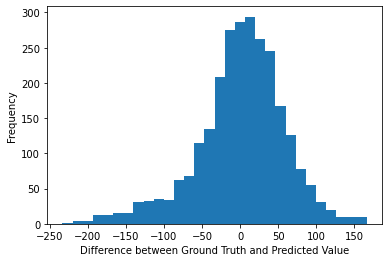

In [ ]:
y_pred = lasso.predict(x_test)
plt.ylabel("Frequency")
plt.xlabel("Difference between Ground Truth and Predicted Value")
plt.hist(y_test - y_pred, bins=30)

The next method we will use it Principal Components Analysis (PCA) which is a machine learning technique that finds linear combinations of the original predictor variables to explain a large portion of the variation in the dataset. Its goal is to eliminate collinearity and use fewer variables than the original data set. 

PCA is split into two steps, dimension reduction formulation and maximum variance formulation.

The dimension reduction process proceeds as follows:

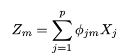

where Z1, Z2,..., ZM represent M<p linear combinations of our original predictors, p. We then fit the linear regression model:


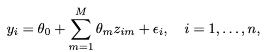

and combining these equations we see

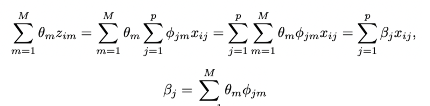

Next, we find the maximum variance formulation. We start by writing into matrix form:

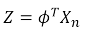![image.png]( 
)

and maximizing via the following:

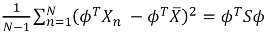

43.49814113921425
3359.4796313462884
57.96101820487877


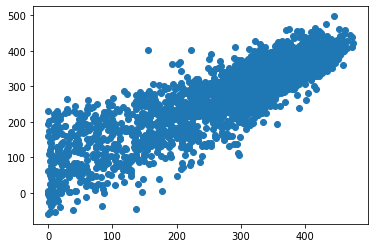

In [ ]:
loc = 'Los Angeles'
df = pd.read_csv(f'{data_dir}processed/{loc}.zip')
df['datetime'] = pd.to_datetime(df.iloc[:, 0:5])
df = df.groupby(df['datetime'].dt.to_period('d')).mean()
y = df['dni']
dropping = ['dhi', 'dni', 'ghi', 'clearsky dhi', 'clearsky dni',
            'clearsky ghi', 'global horizontal uv irradiance (280-400nm)',
       'global horizontal uv irradiance (295-385nm)']
x = df.drop(dropping, axis=1)


from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.33)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)


from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.90)

pca.fit(x_train)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

from sklearn.linear_model import LinearRegression
linearRegr = LinearRegression()

linearRegr.fit(x_train, y_train)
linearRegr.score(x_test, y_test)

y_pred = linearRegr.predict(x_test)
plt.scatter(y_test, y_pred)

from sklearn import metrics

print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


0.7585946948289918


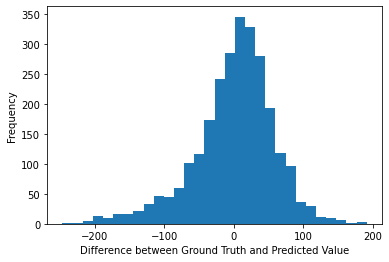

In [ ]:
plt.hist(y_test - y_pred, bins=30)
plt.ylabel("Frequency")
plt.xlabel("Difference between Ground Truth and Predicted Value")
print(linearRegr.score(x_test,y_test))

                           0         1
year               -0.025205 -0.100697
month              -0.099341 -0.167551
day                 0.013606 -0.030853
hour                     NaN       NaN
minute                   NaN       NaN
cloud type          0.108968  0.518285
dew point           0.456622 -0.040405
solar zenith angle -0.334679  0.557451
fill flag           0.015098  0.048829
surface albedo      0.181853 -0.047595
wind speed          0.025777  0.189442
precipitable water  0.276057 -0.092210
wind direction      0.998901 -0.034856
relative humidity   0.565842  0.772960
temperature        -0.071053 -0.744115
pressure           -0.320607  0.139273


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


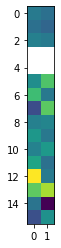

In [ ]:
!pip install matplotlib
import matplotlib.pyplot as plt

principalComponents = pca.fit_transform(x)
corr = pca.components_
features = pca.explained_variance_ratio_
matrix = pca.components_.T * np.sqrt(pca.explained_variance_)

pca_cor = pd.DataFrame(data=[[np.corrcoef(x[c],principalComponents[:,n])[1,0] 
               for n in range(pca.n_components_)] for c in x])
pca_cor.set_index(x.columns, inplace=True)
print(pca_cor)

plt.imshow(pca_cor, cmap=None,interpolation=None) 

# 5. Short-Term Forecast


**Establish a forecast model and predict the data value over the next five time steps over all measurement sites. You should test your method
over several representative scenarios each covering, typically, one day of duration. You must
train your forecast model using data before your testing scenario, while you are free to choose
how much data to train your short-term forecast model.**

### Mathematical Background

We will be training a Long-Short-Term-Memory model (LSTM) on each location in our dataset. LSTM models are a type of Recurrent Neural Networks (RNNs), specially designed to handle time series by retaining long-term dependencies.

LSTM models are characterized by four logical gates, see figure, as well as the cell state, the upper horizontal line. It runs from one timestep to the next, allowing information to percolate through the model.

<img src='https://drive.google.com/uc?id=1as8WKjC7gdrX4T_fxGXFxuqYIBbEsQvV'>

(*figure: Olah, 2015*)

Regarding the four gates, the first one is a forget gate layer, activated by a sigmoid function

$$
f_t = \sigma (W_f \cdot [h_{t-1}, x_t] + b_f)
$$ 

where $W_f$ is a matrix containing the model weights, and note that the subscript  $f$ denotes the gate, $h_{t-1}$ is the hidden layer from the previous timestep, $x_t$ is the model input, $b_t$ is the bias, and

$$
\sigma = \frac{1}{1+e^{-y}}
$$

is the sigmoid activation function for variable $y$. This layer tells us whether we should get rid of previous information in the cell state. The second layer tells us which values to update, as such

$$
i_t = \sigma (W_i \cdot [h_{t-1}, x_t] b_i)
$$

The third layer, generates the potential values to be updated

$$
\tilde{C}_t = \mathrm{tanh}(W_c \cdot [h_{t-1}, x_t] + b_C)
$$

we multiply the second and third gate values together, creating a new cell state $C_t$

$$
C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
$$

That leaves us with the output, $o_t$. We calculate that by

$$
o_t = \sigma (W_o \cdot [h_{t-1}, x_t] + b_o)
$$

Finally, the hidden layer becomes

$$
h_t = o_t \cdot \mathrm{tanh}(C_t)
$$

which progresses to the next timestep (Olah, 2015).


We're going to start off with visualizing PCA. We have an enormous dataset, so for the sake of computational efficiency we might benefit from reducing the dimensionality. This is also a good idea since meteorological data is bound to have some collinearity.

In [ ]:
class CaliPCA(PCA):
    """Performs PCA on data and plots the analysis,
    inheriting from its superclass PCA (sklearn)
    """

    def __init__(self, n_components=None):
        """Initializing the superclass with number of components
        'None' (default) means that the number of components isn't fixed
        """

        super().__init__(n_components=n_components)
        self.fig, self.ax1 = plt.subplots()
        self.ax2 = self.ax1.twinx()
        plot_size(7, 5, 80)

    def standardize(self, df):
        """Standardizes the data (mean=0, variance=1)
        a necessary step for PCA
        """

        scaled = sklearn.preprocessing.scale(df)
        self.fit(scaled)
        self.var = self.explained_variance_
        self.var_cumsum = np.cumsum(self.explained_variance_ratio_) * 100
        self.x = list(range(1, len(self.var_cumsum) + 1))

    def leftplot(self, c=colors['blue'], z=2):
        """Plots the cumulative sum"""
        y = self.var_cumsum
        self.ax1.plot(self.x, y, c=c, zorder=z)
        self.ax1.scatter(self.x, y, c=c, edgecolors='k', zorder=z+1)

    def rightplot(self, c=colors['orange'], z=2):
        """Plots the variance"""
        y = self.var
        self.ax2.plot(self.x, y, c=c, zorder=z)
        self.ax2.scatter(self.x, y, c=c, edgecolors='k', zorder=z+1)

    def props(self):
        """Sets plot properties"""

        self.ax1.set_title('PCA Analysis')
        self.ax1.set_xticks(np.arange(0, len(self.var_cumsum)+1, 1))
        self.ax1.set_xlabel('PCA Dim')
        self.ax1.grid()

        self.ax1.set_ylabel('Cumulative Sum [%]', c=colors['Blue'])
        # Horizontal line to show 90% mark
        self.ax1.axhline(y=90, c=colors['blue'],
                         linestyle='--', linewidth=3, zorder=1)
        self.ax1.set_ylim((0, 100))
        self.ax1.set_yticks(np.arange(0, 110, 10))

        self.ax2.set_ylabel('Variance []', c=colors['orange'])
        # Horizontal line to show where variance crosses 1
        # Usually we don't use the components less than 1
        self.ax2.axhline(y=1, c=colors['orange'],
                         linestyle='--', linewidth=3, zorder=1)
        self.ax2.set_ylim((0, 10))
        self.ax2.set_yticks(np.arange(0, 11, 1))

Executing the PCA

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


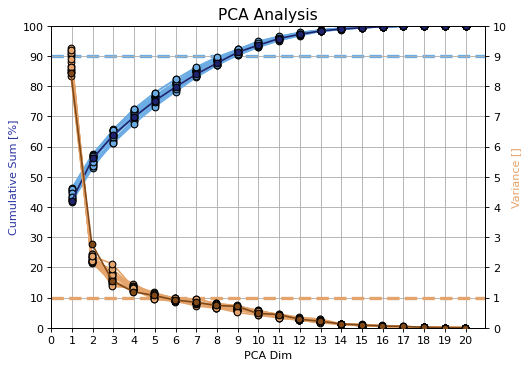

In [ ]:
pca = CaliPCA()
X = np.zeros((2*24*365*15*22, 20))  # Preallocating for a matrix which contains all of the data
location = pd.DataFrame(X[:, 0], columns=['location'])
for i, key in enumerate(locs):
    df = pd.read_csv(f'{data_dir}processed/{key}.zip')
    # 10e11 b/c sklearn warns about the magnitude of datetime
    df['datetime'] = pd.to_datetime(df.iloc[:, 0:5]).astype(int) / 10e11
    # We don't want to use the year, month, day, hour, minute columns
    # The 'drop' command removes those
    df.drop(df.columns[0:5], axis=1, inplace=True)
    N = df.shape[0]
    X[i*N:(i+1)*N, :] = df  # Filling in at the appropriate indices
    location.iloc[i*N:(i+1)*N, :] = key

    pca.standardize(df)
    pca.rightplot()
    pca.leftplot()

# PCA on entire dataset
pca.standardize(X)
pca.rightplot(c=colors['Orange'], z=3)
pca.leftplot(c=colors['BLUE'], z=3)
pca.props()

From the plot we infer that we can keep over 75% of the variance using only 5 principal components out of 20, which is fantastic, as this will improve training times for our LSTM Model.

We now preprocess the data using PCA and run a LSTM model on every location.

In [ ]:
look_back = 48
look_ahead = 5
pca_n_comp = 5
units = 32

pca = PCA(pca_n_comp)
min_max_scaler = sklearn.preprocessing.MinMaxScaler()


def create_window(data, window_shape, step=1, start_id=None, end_id=None):
    """Generates a window for minibatch training on LSTM model.
    
    Original code from here: https://bit.ly/3a1hBCn, with modifications
    by gt2447/mg3777.
    """
    
    data = np.asarray(data)
    data = data.reshape(-1,1) if np.prod(data.shape) == max(data.shape) else data
        
    start_id = 0 if start_id is None else start_id
    end_id = data.shape[0] if end_id is None else end_id
    
    data = data[int(start_id):int(end_id),:]
    window_shape = (int(window_shape), data.shape[-1])
    step = (int(step),) * data.ndim
    slices = tuple(slice(None, None, st) for st in step)
    indexing_strides = data[slices].strides
    win_indices_shape = ((np.array(data.shape) - window_shape) // step) + 1
    
    new_shape = tuple(list(win_indices_shape) + list(window_shape))
    strides = tuple(list(indexing_strides) + list(data.strides))
    
    window_data = np.lib.stride_tricks.as_strided(data,
                                                  shape=new_shape,
                                                  strides=strides)
    
    return np.squeeze(window_data, 1)


def create_model():
    """Generates a LSTM model"""

    model = keras.Sequential()
    model.add(layers.Input(shape=(look_back, pca_n_comp)))
    model.add(layers.LSTM(units=units, return_sequences=True))
    model.add(layers.Dropout(0.5))
    model.add(layers.LSTM(units=units))
    model.add(layers.Dense(units=units))
    model.add(layers.Dense(units=1))

    return model


model = create_model()
model.compile(optimizer='Adam',
              loss='mse',
              metrics=['accuracy'])

for i, location in enumerate(locs.keys()):
    X = pd.read_csv(f'{data_dir}processed/{location}.zip')

    # Processing y_train
    y_train = X.dni
    y_train = y_train.to_numpy()
    y_train = y_train.reshape(-1, 1)
    y_train = sklearn.preprocessing.normalize(y_train)
    y_train = create_window(y_train,
                            window_shape=look_ahead,
                            start_id=look_back)

    # Processing X_train
    scaled = sklearn.preprocessing.scale(X)
    pca.fit_transform(scaled)
    eigenvectors = pca.components_.T
    X_train = X @ eigenvectors
    np_scaled = min_max_scaler.fit_transform(X_train)
    X_train = pd.DataFrame(np_scaled, columns=X_train.columns)
    X_train = create_window(X_train,
                            window_shape=look_back,
                            end_id=-look_ahead)
    
    if i == 0:
        print(f'X_train shape: {X_train.shape}')
        print(f'y_train shape: {y_train.shape}')

    print(location.upper())
    model.fit(x=X_train, 
              y=y_train,
              batch_size=look_back,
              epochs=1,
              validation_split=0.4)

X_train shape: (385388, 48, 5)
y_train shape: (385388, 5, 1)
CHICO
4818/4818 [==============================] - 78s 9ms/step - loss: 0.0745 - accuracy: 0.8963 - val_loss: 0.0545 - val_accuracy: 0.9211
FRESNO
4818/4818 [==============================] - 44s 9ms/step - loss: 0.0531 - accuracy: 0.9235 - val_loss: 0.0506 - val_accuracy: 0.9262
BAKERSFIELD
4818/4818 [==============================] - 44s 9ms/step - loss: 0.0521 - accuracy: 0.9247 - val_loss: 0.0487 - val_accuracy: 0.9296
LOS ANGELES
4818/4818 [==============================] - 44s 9ms/step - loss: 0.0542 - accuracy: 0.9210 - val_loss: 0.0524 - val_accuracy: 0.9239
EUREKA
4818/4818 [==============================] - 44s 9ms/step - loss: 0.0704 - accuracy: 0.8967 - val_loss: 0.0675 - val_accuracy: 0.9007
MERCED
4818/4818 [==============================] - 43s 9ms/step - loss: 0.0527 - accuracy: 0.9229 - val_loss: 0.0478 - val_accuracy: 0.9300
SAN FRANCISCO
4818/4818 [==============================] - 44s 9ms/step - loss: 0.06

It should be noted that using 1 epoch for each location is rather unusual, but the validation accuracy doesn't improve significantly after the first epoch which validates this approach.

This simple architecture of only two LSTM layers with a dropout of 0.5 performed as well as deeper models (10 layers) we tested with no dropout. 

The result is an average validation accuracy for the next five time steps 93% for each location, with a minimum of 90%, using an input size of 48 values (last 24 hours). The high validation accuracy indicates good generalization, and thus a fully satisfactory result. 

# References

[Weather Data](https://www.nrel.gov/grid/solar-resource/renewable-resource-data.html)

[California geospatial raster data](https://data.ca.gov/dataset/ca-geographic-boundaries)



[California shoreline](https://purl.stanford.edu/xv279yj9196)

DNI vs. solar power potential:
M. Schlecht, R. Meyer, 2012. *Site selection and feasibility analysis for concentrating solar power (CSP) systems.* https://doi.org/10.1533/9780857096173.1.91.

James et al. 2013. An Introduction to Statistical Learning w. Applications in R

Christopher Olah. 2015. [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/#:~:text=Long%20Short%20Term%20Memory%20networks,many%20people%20in%20following%20work)

Documentation for various packages

Deep Learning. 2016. Goodfellow et al.


